### Testing access to the NHL API

In [5]:
import pandas as pd
from nhlpy.api.query.builder import QueryBuilder, QueryContext
from nhlpy.nhl_client import NHLClient
from nhlpy.api.query.filters.franchise import FranchiseQuery
from nhlpy.api.query.filters.shoot_catch import ShootCatchesQuery
from nhlpy.api.query.filters.draft import DraftQuery
from nhlpy.api.query.filters.season import SeasonQuery
from nhlpy.api.query.filters.game_type import GameTypeQuery
from nhlpy.api.query.filters.position import PositionQuery, PositionTypes
from nhlpy.api.query.filters.status import StatusQuery
from nhlpy.api.query.filters.opponent import OpponentQuery
from nhlpy.api.query.filters.home_road import HomeRoadQuery
from nhlpy.api.query.filters.experience import ExperienceQuery
from nhlpy.api.query.filters.decision import DecisionQuery
import datetime

In [6]:
client = NHLClient(verbose=True)

In [7]:
print(client)

## Team info prep

Using teams_info method with date parameter fetches inforamtion about the team for the given date.

In [8]:
date = datetime.datetime.now().strftime("%Y-%m-%d")
team_info = client.teams.teams_info(date=date)

INFO:httpx:HTTP Request: GET https://api-web.nhle.com/v1/standings/2025-02-16 "HTTP/1.1 200 OK"
INFO:root:API URL: https://api-web.nhle.com/v1/standings/2025-02-16
INFO:httpx:HTTP Request: GET https://api.nhle.com/stats/rest/en/franchise "HTTP/1.1 200 OK"
INFO:root:API URL: https://api.nhle.com/stats/rest/en/franchise


In [9]:
df_team_info = pd.DataFrame(team_info)

In [10]:
df_team_info.head()

,conference,division,name,common_name,abbr,logo,franchise_id
0,"{'abbr': 'W', 'name': 'Western'}","{'abbr': 'C', 'name': 'Central'}",Winnipeg Jets,Jets,WPG,https://assets.nhle.com/logos/nhl/svg/WPG_ligh...,35
1,"{'abbr': 'E', 'name': 'Eastern'}","{'abbr': 'M', 'name': 'Metropolitan'}",Washington Capitals,Capitals,WSH,https://assets.nhle.com/logos/nhl/svg/WSH_seco...,24
2,"{'abbr': 'W', 'name': 'Western'}","{'abbr': 'C', 'name': 'Central'}",Dallas Stars,Stars,DAL,https://assets.nhle.com/logos/nhl/svg/DAL_ligh...,15
3,"{'abbr': 'W', 'name': 'Western'}","{'abbr': 'P', 'name': 'Pacific'}",Edmonton Oilers,Oilers,EDM,https://assets.nhle.com/logos/nhl/svg/EDM_ligh...,25
4,"{'abbr': 'W', 'name': 'Western'}","{'abbr': 'P', 'name': 'Pacific'}",Vegas Golden Knights,Golden Knights,VGK,https://assets.nhle.com/logos/nhl/svg/VGK_ligh...,38


Data in some fields is stored as a dictionary with abbreviated and full names, namely for Conference and Division.

We can access a full name value under a given key with the get method:

In [11]:
df_team_info["conference"].apply(lambda x: x.get("name") if isinstance(x, dict) else x).unique()

array(['Western', 'Eastern'], dtype=object)

Now wrapping it under a function that accepts a column name and a dictionary key as arguments.

In [12]:
def get_default_value(column, get_value):
    return column.apply(lambda x: x.get(get_value) if isinstance(x, dict) else x)

Create a loop to go through columns we want to change.

In [13]:
columns_to_change = ["conference", "division"]

for column in columns_to_change:
    df_team_info[column] = get_default_value(df_team_info[column], "name")

In [14]:
df_team_info.head()

,conference,division,name,common_name,abbr,logo,franchise_id
0,Western,Central,Winnipeg Jets,Jets,WPG,https://assets.nhle.com/logos/nhl/svg/WPG_ligh...,35
1,Eastern,Metropolitan,Washington Capitals,Capitals,WSH,https://assets.nhle.com/logos/nhl/svg/WSH_seco...,24
2,Western,Central,Dallas Stars,Stars,DAL,https://assets.nhle.com/logos/nhl/svg/DAL_ligh...,15
3,Western,Pacific,Edmonton Oilers,Oilers,EDM,https://assets.nhle.com/logos/nhl/svg/EDM_ligh...,25
4,Western,Pacific,Vegas Golden Knights,Golden Knights,VGK,https://assets.nhle.com/logos/nhl/svg/VGK_ligh...,38


Saving teams abbreviations as a series for further iterations. 

In [15]:
s_teams = df_team_info["abbr"]

In [16]:
s_teams.info()

<class 'pandas.core.series.Series'>
RangeIndex: 32 entries, 0 to 31
Series name: abbr
Non-Null Count  Dtype 
--------------  ----- 
32 non-null     object
dtypes: object(1)
memory usage: 388.0+ bytes


## Roster Data analysis

In roster table, we want to get players attributes for further filtering

In [17]:
# Select a season and a team to perform a query
season_id = 20242025
team_abbr = "COL"

In [18]:
roster_data = client.teams.roster(team_abbr=team_abbr, season=season_id)

INFO:httpx:HTTP Request: GET https://api-web.nhle.com/v1/roster/COL/20242025 "HTTP/1.1 200 OK"
INFO:root:API URL: https://api-web.nhle.com/v1/roster/COL/20242025


Let's inspect the object we received from the query.

In [19]:
roster_data

{'forwards': [{'id': 8479525,
   'headshot': 'https://assets.nhle.com/mugs/nhl/20242025/COL/8479525.png',
   'firstName': {'default': 'Ross'},
   'lastName': {'default': 'Colton'},
   'sweaterNumber': 20,
   'positionCode': 'C',
   'shootsCatches': 'L',
   'heightInInches': 72,
   'weightInPounds': 194,
   'heightInCentimeters': 183,
   'weightInKilograms': 88,
   'birthDate': '1996-09-11',
   'birthCity': {'default': 'Robbinsville'},
   'birthCountry': 'USA',
   'birthStateProvince': {'default': 'NJ'}},
  {'id': 8477494,
   'headshot': 'https://assets.nhle.com/mugs/nhl/20242025/COL/8477494.png',
   'firstName': {'default': 'Jonathan'},
   'lastName': {'default': 'Drouin'},
   'sweaterNumber': 27,
   'positionCode': 'L',
   'shootsCatches': 'L',
   'heightInInches': 71,
   'weightInPounds': 198,
   'heightInCentimeters': 180,
   'weightInKilograms': 90,
   'birthDate': '1995-03-28',
   'birthCity': {'default': 'Ste-Agathe'},
   'birthCountry': 'CAN',
   'birthStateProvince': {'default'

The returned dictionary contains positions as keys and list of dictionaries with individual players' info as values. Let's inspect the goalies record. 

In [20]:
roster_data["goalies"]

[{'id': 8478406,
  'headshot': 'https://assets.nhle.com/mugs/nhl/20242025/COL/8478406.png',
  'firstName': {'default': 'Mackenzie'},
  'lastName': {'default': 'Blackwood'},
  'sweaterNumber': 39,
  'positionCode': 'G',
  'shootsCatches': 'L',
  'heightInInches': 76,
  'weightInPounds': 225,
  'heightInCentimeters': 193,
  'weightInKilograms': 102,
  'birthDate': '1996-12-09',
  'birthCity': {'default': 'Thunder Bay'},
  'birthCountry': 'CAN',
  'birthStateProvince': {'default': 'ON'}},
 {'id': 8475809,
  'headshot': 'https://assets.nhle.com/mugs/nhl/20242025/COL/8475809.png',
  'firstName': {'default': 'Scott'},
  'lastName': {'default': 'Wedgewood'},
  'sweaterNumber': 41,
  'positionCode': 'G',
  'shootsCatches': 'L',
  'heightInInches': 74,
  'weightInPounds': 201,
  'heightInCentimeters': 188,
  'weightInKilograms': 91,
  'birthDate': '1992-08-14',
  'birthCity': {'default': 'Brampton'},
  'birthCountry': 'CAN',
  'birthStateProvince': {'default': 'ON'}}]

We can combine all three values for defensemen, forwards and goales in a list and convert that into a dataframe for cleaning and analysis.

In [21]:
roster_data_combined = roster_data["forwards"] + roster_data["defensemen"] + roster_data ["goalies"]

In [22]:
df_team_roster = pd.DataFrame(roster_data_combined)

In [23]:
df_team_roster.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23 entries, 0 to 22
Data columns (total 15 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   id                   23 non-null     int64 
 1   headshot             23 non-null     object
 2   firstName            23 non-null     object
 3   lastName             23 non-null     object
 4   sweaterNumber        23 non-null     int64 
 5   positionCode         23 non-null     object
 6   shootsCatches        23 non-null     object
 7   heightInInches       23 non-null     int64 
 8   weightInPounds       23 non-null     int64 
 9   heightInCentimeters  23 non-null     int64 
 10  weightInKilograms    23 non-null     int64 
 11  birthDate            23 non-null     object
 12  birthCity            23 non-null     object
 13  birthCountry         23 non-null     object
 14  birthStateProvince   17 non-null     object
dtypes: int64(6), object(9)
memory usage: 2.8+ KB


In [24]:
df_team_roster.head()

,id,headshot,firstName,lastName,sweaterNumber,positionCode,shootsCatches,heightInInches,weightInPounds,heightInCentimeters,weightInKilograms,birthDate,birthCity,birthCountry,birthStateProvince
0,8479525,https://assets.nhle.com/mugs/nhl/20242025/COL/...,{'default': 'Ross'},{'default': 'Colton'},20,C,L,72,194,183,88,1996-09-11,{'default': 'Robbinsville'},USA,{'default': 'NJ'}
1,8477494,https://assets.nhle.com/mugs/nhl/20242025/COL/...,{'default': 'Jonathan'},{'default': 'Drouin'},27,L,L,71,198,180,90,1995-03-28,{'default': 'Ste-Agathe'},CAN,{'default': 'QC'}
2,8480835,https://assets.nhle.com/mugs/nhl/20242025/COL/...,{'default': 'Jack'},{'default': 'Drury'},18,C,L,71,186,180,84,2000-02-03,{'default': 'New York'},USA,{'default': 'NY'}
3,8480448,https://assets.nhle.com/mugs/nhl/20242025/COL/...,{'default': 'Parker'},{'default': 'Kelly'},17,C,L,73,185,185,84,1999-05-14,{'default': 'Camrose'},CAN,{'default': 'AB'}
4,8481641,https://assets.nhle.com/mugs/nhl/20242025/COL/...,{'default': 'Joel'},{'default': 'Kiviranta'},94,L,L,71,185,180,84,1996-03-23,"{'default': 'Vantaa', 'sv': 'Vanda'}",FIN,NaN


Data in some of the fields is represented as dictionaries with information like First and Last Names and Birth City can be presented in multiple languages. Let's inspect them to understand how we can transform the data to make analysis easy.   

In [25]:
df_team_roster.loc[ : ,["firstName", "lastName", "birthCity", "birthStateProvince", "birthCountry"]]

,firstName,lastName,birthCity,birthStateProvince,birthCountry
0,{'default': 'Ross'},{'default': 'Colton'},{'default': 'Robbinsville'},{'default': 'NJ'},USA
1,{'default': 'Jonathan'},{'default': 'Drouin'},{'default': 'Ste-Agathe'},{'default': 'QC'},CAN
2,{'default': 'Jack'},{'default': 'Drury'},{'default': 'New York'},{'default': 'NY'},USA
3,{'default': 'Parker'},{'default': 'Kelly'},{'default': 'Camrose'},{'default': 'AB'},CAN
4,{'default': 'Joel'},{'default': 'Kiviranta'},"{'default': 'Vantaa', 'sv': 'Vanda'}",NaN,FIN
5,{'default': 'Artturi'},{'default': 'Lehkonen'},"{'default': 'Piikkio', 'cs': 'Piikkiö', 'fi': ...",NaN,FIN
6,{'default': 'Nathan'},{'default': 'MacKinnon'},{'default': 'Halifax'},{'default': 'NS'},CAN
7,{'default': 'Casey'},{'default': 'Mittelstadt'},{'default': 'Eden Prairie'},{'default': 'MN'},USA
8,{'default': 'Martin'},"{'default': 'Necas', 'cs': 'Nečas', 'sk': 'Neč...",{'default': 'Nove Mesto na Morave'},NaN,CZE
9,"{'default': 'Valeri', 'cs': 'Valerij', 'sk': '...","{'default': 'Nichushkin', 'cs': 'Ničuškin', 'f...","{'default': 'Chelyabinsk', 'cs': 'Čeljabinsk',...",NaN,RUS


We can reuse the function we created earlier to extract values under "default" key, which is English spellings.

In [26]:
# Test the function on the Last Name column
get_default_value(df_team_roster["lastName"], "default").tail(10)

13      de Haan
14       Girard
15    Kylington
16        Makar
17     Malinski
18       Manson
19    Middleton
20        Toews
21    Blackwood
22    Wedgewood
Name: lastName, dtype: object

Now in the dataframe, we apply the function to the fields we want to be cleaned.

In [27]:
columns_to_change = ["firstName", "lastName", "birthCity", "birthStateProvince"]

for column in columns_to_change:
    df_team_roster[column] = get_default_value(df_team_roster[column], "default")

In [29]:
df_team_roster.loc[df_team_roster["lastName"] == "Necas"].T

,8
id,8480039
headshot,https://assets.nhle.com/mugs/nhl/20242025/COL/...
firstName,Martin
lastName,Necas
sweaterNumber,88
positionCode,C
shootsCatches,R
heightInInches,75
weightInPounds,195
heightInCentimeters,191


For the purpose of our project we don't need certain fields such as "birthCity", "birthStateProvince", "weightInPounds" etc.

In [30]:
df_team_roster.drop(
    columns=["heightInInches", "weightInPounds", "birthCity", "birthStateProvince"],
    axis=1,
    inplace=True
)

In [31]:
df_team_roster.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23 entries, 0 to 22
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   id                   23 non-null     int64 
 1   headshot             23 non-null     object
 2   firstName            23 non-null     object
 3   lastName             23 non-null     object
 4   sweaterNumber        23 non-null     int64 
 5   positionCode         23 non-null     object
 6   shootsCatches        23 non-null     object
 7   heightInCentimeters  23 non-null     int64 
 8   weightInKilograms    23 non-null     int64 
 9   birthDate            23 non-null     object
 10  birthCountry         23 non-null     object
dtypes: int64(4), object(7)
memory usage: 2.1+ KB


To be able to repeatedly clean data for all franchises, we create a function that will be reused in a loop.

In [38]:
def get_team_roster(team_abbr, season_id):
    
    # Load data
    data = client.teams.roster(team_abbr=team_abbr, season=season_id)
    data_combined = data["forwards"] + data["defensemen"] + data ["goalies"]
    df = pd.DataFrame(data_combined)
    df["team_abbr"] = team_abbr

    if df.shape[1] > 0:
        # Clean columns
        columns_to_change = ["firstName", "lastName", "birthCity", "birthStateProvince"]
        for column in columns_to_change:
            df[column] = get_default_value(df[column], "default")

        # Drop columns
        df.drop(
            columns=["heightInInches", "weightInPounds", "birthCity", "birthStateProvince"],
            axis=1,
            inplace=True
        )

    return df

In [39]:
get_team_roster("DAL", "20242025").head()

INFO:httpx:HTTP Request: GET https://api-web.nhle.com/v1/roster/DAL/20242025 "HTTP/1.1 200 OK"
INFO:root:API URL: https://api-web.nhle.com/v1/roster/DAL/20242025


,id,headshot,firstName,lastName,sweaterNumber,positionCode,shootsCatches,heightInCentimeters,weightInKilograms,birthDate,birthCountry,team_abbr
0,8473994,https://assets.nhle.com/mugs/nhl/20242025/DAL/...,Jamie,Benn,14,L,L,191,93,1989-07-18,CAN,DAL
1,8476278,https://assets.nhle.com/mugs/nhl/20242025/DAL/...,Colin,Blackwell,15,C,R,173,86,1993-03-28,USA,DAL
2,8482145,https://assets.nhle.com/mugs/nhl/20242025/DAL/...,Mavrik,Bourque,22,C,R,180,82,2002-01-08,CAN,DAL
3,8480840,https://assets.nhle.com/mugs/nhl/20242025/DAL/...,Oskar,Bäck,10,C,L,193,92,2000-03-12,SWE,DAL
4,8474149,https://assets.nhle.com/mugs/nhl/20242025/DAL/...,Evgenii,Dadonov,63,R,L,180,85,1989-03-12,RUS,DAL


Checking what value is assigned to the season_id variable which we will use in the get_team_roster functions

In [40]:
season_id

20242025

In [41]:
list_of_roster_dfs = [] # Creating a list to store team rosters dataframes

for index, team in s_teams.items():
    df = get_team_roster(team, season_id)
    list_of_roster_dfs.append(df)

INFO:httpx:HTTP Request: GET https://api-web.nhle.com/v1/roster/WPG/20242025 "HTTP/1.1 200 OK"
INFO:root:API URL: https://api-web.nhle.com/v1/roster/WPG/20242025
INFO:httpx:HTTP Request: GET https://api-web.nhle.com/v1/roster/WSH/20242025 "HTTP/1.1 200 OK"
INFO:root:API URL: https://api-web.nhle.com/v1/roster/WSH/20242025
INFO:httpx:HTTP Request: GET https://api-web.nhle.com/v1/roster/DAL/20242025 "HTTP/1.1 200 OK"
INFO:root:API URL: https://api-web.nhle.com/v1/roster/DAL/20242025
INFO:httpx:HTTP Request: GET https://api-web.nhle.com/v1/roster/EDM/20242025 "HTTP/1.1 200 OK"
INFO:root:API URL: https://api-web.nhle.com/v1/roster/EDM/20242025
INFO:httpx:HTTP Request: GET https://api-web.nhle.com/v1/roster/VGK/20242025 "HTTP/1.1 200 OK"
INFO:root:API URL: https://api-web.nhle.com/v1/roster/VGK/20242025
INFO:httpx:HTTP Request: GET https://api-web.nhle.com/v1/roster/FLA/20242025 "HTTP/1.1 200 OK"
INFO:root:API URL: https://api-web.nhle.com/v1/roster/FLA/20242025
INFO:httpx:HTTP Request: GET

In [42]:
list_of_roster_dfs

[         id                                           headshot  firstName  \
 0   8478891  https://assets.nhle.com/mugs/nhl/20242025/WPG/...      Mason   
 1   8480289  https://assets.nhle.com/mugs/nhl/20242025/WPG/...     Morgan   
 2   8478398  https://assets.nhle.com/mugs/nhl/20242025/WPG/...       Kyle   
 3   8477940  https://assets.nhle.com/mugs/nhl/20242025/WPG/...    Nikolaj   
 4   8481019  https://assets.nhle.com/mugs/nhl/20242025/WPG/...      David   
 5   8480113  https://assets.nhle.com/mugs/nhl/20242025/WPG/...       Alex   
 6   8480845  https://assets.nhle.com/mugs/nhl/20242025/WPG/...     Rasmus   
 7   8476392  https://assets.nhle.com/mugs/nhl/20242025/WPG/...       Adam   
 8   8476480  https://assets.nhle.com/mugs/nhl/20242025/WPG/...  Vladislav   
 9   8475799  https://assets.nhle.com/mugs/nhl/20242025/WPG/...       Nino   
 10  8482149  https://assets.nhle.com/mugs/nhl/20242025/WPG/...       Cole   
 11  8476460  https://assets.nhle.com/mugs/nhl/20242025/WPG/... 

Using concat method we combine the dataframes in the list into a single dataframe.

In [43]:
df_team_roster_combined = pd.concat(list_of_roster_dfs)

In [44]:
df_team_roster_combined.info() 

<class 'pandas.core.frame.DataFrame'>
Index: 737 entries, 0 to 23
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   id                   737 non-null    int64  
 1   headshot             737 non-null    object 
 2   firstName            737 non-null    object 
 3   lastName             737 non-null    object 
 4   sweaterNumber        735 non-null    float64
 5   positionCode         737 non-null    object 
 6   shootsCatches        737 non-null    object 
 7   heightInCentimeters  737 non-null    int64  
 8   weightInKilograms    737 non-null    int64  
 9   birthDate            737 non-null    object 
 10  birthCountry         737 non-null    object 
 11  team_abbr            737 non-null    object 
dtypes: float64(1), int64(3), object(8)
memory usage: 74.9+ KB


To test the combined dataframe, let's run a few queries.
Who is the tallest skater in the league? 

In [45]:
df_team_roster_combined.loc[df_team_roster_combined["heightInCentimeters"] == df_team_roster_combined["heightInCentimeters"].max()]

,id,headshot,firstName,lastName,sweaterNumber,positionCode,shootsCatches,heightInCentimeters,weightInKilograms,birthDate,birthCountry,team_abbr
9,8482460,https://assets.nhle.com/mugs/nhl/20242025/NYR/...,Matt,Rempe,73.0,C,R,206,116,2002-06-29,CAN,NYR


Who is the oldest Canadian goalie?

In [46]:
df_team_roster_combined.loc[
    (df_team_roster_combined['birthDate'] == df_team_roster_combined['birthDate'].min()) &
    (df_team_roster_combined['birthCountry'].str.upper() == 'CAN') &
    (df_team_roster_combined['positionCode'].str.upper() == 'G')
    ]

,id,headshot,firstName,lastName,sweaterNumber,positionCode,shootsCatches,heightInCentimeters,weightInKilograms,birthDate,birthCountry,team_abbr
21,8470594,https://assets.nhle.com/mugs/nhl/20242025/MIN/...,Marc-Andre,Fleury,29.0,G,L,188,84,1984-11-28,CAN,MIN


In [48]:
df_team_roster_combined.loc[df_team_roster_combined["id"] == 8475809].T

,22
id,8475809
headshot,https://assets.nhle.com/mugs/nhl/20242025/COL/...
firstName,Scott
lastName,Wedgewood
sweaterNumber,41.0
positionCode,G
shootsCatches,L
heightInCentimeters,188
weightInKilograms,91
birthDate,1992-08-14


As goalies stats track different event compared to skaters, we pull stats for them separately.

In [49]:
df_team_roster_combined['positionCode'].unique()

array(['C', 'L', 'R', 'D', 'G'], dtype=object)

Saving skaters into a series.

In [50]:
s_skater_ids = df_team_roster_combined.loc[df_team_roster_combined['positionCode'] != "G"]['id']

In [51]:
s_skater_ids.info()

s_skater_ids.head()

<class 'pandas.core.series.Series'>
Index: 670 entries, 0 to 21
Series name: id
Non-Null Count  Dtype
--------------  -----
670 non-null    int64
dtypes: int64(1)
memory usage: 10.5 KB


0    8478891
1    8480289
2    8478398
3    8477940
4    8481019
Name: id, dtype: int64

Saving goalies ids into a series.

In [52]:
s_goalie_ids = df_team_roster_combined.loc[df_team_roster_combined['positionCode'] == "G"]['id']

In [53]:
s_goalie_ids.info()

s_goalie_ids.head()

<class 'pandas.core.series.Series'>
Index: 67 entries, 21 to 23
Series name: id
Non-Null Count  Dtype
--------------  -----
67 non-null     int64
dtypes: int64(1)
memory usage: 1.0 KB


21    8477480
22    8476945
24    8479292
25    8480313
22    8479193
Name: id, dtype: int64

## Game logs data prep

Game logs method requires player id, season id and game type arguments.
We can reuse the season id we declared earlier, while declaring the player id (Nathan MacKinnon) and game type (Regular Season) below.

In [54]:
player_id = 8477492
game_type = 2

In [55]:
game_logs_data = client.stats.player_game_log(player_id=player_id, season_id=season_id, game_type=game_type)

INFO:httpx:HTTP Request: GET https://api-web.nhle.com/v1/player/8477492/game-log/20242025/2 "HTTP/1.1 200 OK"
INFO:root:API URL: https://api-web.nhle.com/v1/player/8477492/game-log/20242025/2


In [56]:
df_game_logs = pd.DataFrame(game_logs_data)

In [57]:
df_game_logs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57 entries, 0 to 56
Data columns (total 21 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   gameId              57 non-null     int64 
 1   teamAbbrev          57 non-null     object
 2   homeRoadFlag        57 non-null     object
 3   gameDate            57 non-null     object
 4   goals               57 non-null     int64 
 5   assists             57 non-null     int64 
 6   commonName          57 non-null     object
 7   opponentCommonName  57 non-null     object
 8   points              57 non-null     int64 
 9   plusMinus           57 non-null     int64 
 10  powerPlayGoals      57 non-null     int64 
 11  powerPlayPoints     57 non-null     int64 
 12  gameWinningGoals    57 non-null     int64 
 13  otGoals             57 non-null     int64 
 14  shots               57 non-null     int64 
 15  shifts              57 non-null     int64 
 16  shorthandedPoints   57 non-n

Inspecting the most recent record and transposing for better readability.

In [58]:
df_game_logs.head(1).T

,0
gameId,2024020874
teamAbbrev,COL
homeRoadFlag,R
gameDate,2025-02-07
goals,1
assists,3
commonName,{'default': 'Avalanche'}
opponentCommonName,{'default': 'Oilers'}
points,4
plusMinus,2


There are a few columns we can drop as they are not required / could be found in the team info table.

In [59]:
df_game_logs.drop(columns=["commonName", "opponentCommonName"], inplace=True)

For TOI (Time on Ice) field, we convert the values to seconds to allow easier aggregations.

In [60]:
# Check if the TOI is in MM:SS format
if len(df_game_logs["toi"][0].split(":")) == 2:
    # If so, convert to seconds by multiplying minutes by 60 and adding the seconds value.
    print(int(df_game_logs["toi"][0].split(":")[0]) * 60 + int(df_game_logs["toi"][0].split(":")[1]))
else:
    # if not, calculate hours first (mostly for goalies)
    print(int(df_game_logs["toi"][0].split(":")[0]) * 60 * 60 + int(df_game_logs["toi"][0].split(":")[1]) * 60 + int(df_game_logs["toi"][0].split(":")[2]))

1338


Translate the above if-else into a lambda function that can be applied to all rows

In [61]:
df_game_logs["toi"].apply(
    lambda x: 
        int(x.split(":")[0]) * 60 + int(x.split(":")[1])
        if len(x.split(":")) == 2
        else int(x.split(":")[0]) * 60 * 60 + int(x.split(":")[1]) * 60 + int(x.split(":")[2])
    )

0     1338
1     1367
2     1305
3     1467
4     1230
5     1433
6     1115
7     1428
8     1439
9     1557
10    1245
11    1272
12    1507
13    1457
14    1184
15    1639
16    1405
17    1524
18    1576
19    1392
20    1148
21    1256
22    1129
23    1398
24    1501
25    1286
26    1417
27    1056
28    1306
29    1367
30    1505
31    1413
32    1409
33    1562
34    1625
35    1311
36    1344
37    1336
38    1359
39    1326
40    1485
41    1469
42    1579
43    1469
44    1461
45    1352
46    1498
47    1497
48    1394
49    1257
50    1311
51    1200
52    1428
53    1428
54    1380
55    1403
56    1293
Name: toi, dtype: int64

In [62]:
df_game_logs["toi"] = df_game_logs["toi"].apply(
    lambda x: 
        int(x.split(":")[0]) * 60 + int(x.split(":")[1])
        if len(x.split(":")) == 2
        else int(x.split(":")[0]) * 60 * 60 + int(x.split(":")[1]) * 60 + int(x.split(":")[2])
    )

As we are going to loop through players in each franchise, we assign player id and season id for further analysis as they aren't included.

In [63]:
df_game_logs["playerId"] = player_id
df_game_logs["seasonId"] = season_id

In [64]:
df_game_logs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57 entries, 0 to 56
Data columns (total 21 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   gameId             57 non-null     int64 
 1   teamAbbrev         57 non-null     object
 2   homeRoadFlag       57 non-null     object
 3   gameDate           57 non-null     object
 4   goals              57 non-null     int64 
 5   assists            57 non-null     int64 
 6   points             57 non-null     int64 
 7   plusMinus          57 non-null     int64 
 8   powerPlayGoals     57 non-null     int64 
 9   powerPlayPoints    57 non-null     int64 
 10  gameWinningGoals   57 non-null     int64 
 11  otGoals            57 non-null     int64 
 12  shots              57 non-null     int64 
 13  shifts             57 non-null     int64 
 14  shorthandedPoints  57 non-null     int64 
 15  shorthandedGoals   57 non-null     int64 
 16  opponentAbbrev     57 non-null     object
 17 

Create a function to load and clean game logs data.

In [65]:
def get_game_logs(player_id, season_id, game_type):
    
    # Get the data
    data = client.stats.player_game_log(player_id=player_id, season_id=season_id, game_type=game_type)
    df = pd.DataFrame(data)
    if df.shape[1] > 0:
        # Drop columns
        df.drop(columns=["commonName", "opponentCommonName"], inplace=True)
        
        # Format time on ice
        df["toiInSeconds"] = df["toi"].apply(
            lambda x: 
                int(x.split(":")[0]) * 60 + int(x.split(":")[1]) 
                if len(x.split(":")) == 2 
                else int(x.split(":")[0]) * 60 * 60 + int(x.split(":")[1]) * 60 + int(x.split(":")[2]))
        df.drop(columns=["toi"], inplace=True)

        # Append player and season ids
        df["playerId"] = player_id
        df["seasonId"] = season_id

    return df

In [66]:
get_game_logs(player_id, season_id, game_type)

INFO:httpx:HTTP Request: GET https://api-web.nhle.com/v1/player/8477492/game-log/20242025/2 "HTTP/1.1 200 OK"
INFO:root:API URL: https://api-web.nhle.com/v1/player/8477492/game-log/20242025/2


,gameId,teamAbbrev,homeRoadFlag,gameDate,goals,assists,points,plusMinus,powerPlayGoals,powerPlayPoints,...,otGoals,shots,shifts,shorthandedGoals,shorthandedPoints,opponentAbbrev,pim,toiInSeconds,playerId,seasonId
0,2024020874,COL,R,2025-02-07,1,3,4,2,1,1,...,0,7,24,0,0,EDM,0,1338,8477492,20242025
1,2024020868,COL,R,2025-02-06,0,3,3,2,0,1,...,0,2,25,0,0,CGY,2,1367,8477492,20242025
2,2024020855,COL,R,2025-02-04,0,0,0,-1,0,0,...,0,5,20,0,0,VAN,0,1305,8477492,20242025
3,2024020836,COL,H,2025-02-02,1,0,1,0,1,1,...,0,4,22,0,0,PHI,0,1467,8477492,20242025
4,2024020824,COL,H,2025-01-31,0,1,1,1,0,1,...,0,4,19,0,0,STL,0,1230,8477492,20242025
5,2024020803,COL,R,2025-01-28,0,1,1,0,0,0,...,0,7,27,0,0,NYI,0,1433,8477492,20242025
6,2024020789,COL,R,2025-01-26,0,2,2,-1,0,1,...,0,1,21,0,0,NYR,0,1115,8477492,20242025
7,2024020776,COL,R,2025-01-25,0,0,0,-1,0,0,...,0,8,23,0,0,BOS,0,1428,8477492,20242025
8,2024020759,COL,H,2025-01-22,1,0,1,0,0,0,...,0,7,26,0,0,WPG,0,1439,8477492,20242025
9,2024020741,COL,H,2025-01-20,1,0,1,1,0,0,...,0,6,25,0,0,MIN,0,1557,8477492,20242025


Goalies game logs stats are returned in a different format to skaters.

In [67]:
goalie_player_id = 8477480

In [68]:
game_logs_data = client.stats.player_game_log(player_id=goalie_player_id, season_id=season_id, game_type=game_type)

INFO:httpx:HTTP Request: GET https://api-web.nhle.com/v1/player/8477480/game-log/20242025/2 "HTTP/1.1 200 OK"
INFO:root:API URL: https://api-web.nhle.com/v1/player/8477480/game-log/20242025/2


In [69]:
df_game_logs_goalies = pd.DataFrame(game_logs_data)

In [70]:
df_game_logs_goalies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13 entries, 0 to 12
Data columns (total 17 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   gameId              13 non-null     int64  
 1   teamAbbrev          13 non-null     object 
 2   homeRoadFlag        13 non-null     object 
 3   gameDate            13 non-null     object 
 4   goals               13 non-null     int64  
 5   assists             13 non-null     int64  
 6   commonName          13 non-null     object 
 7   opponentCommonName  13 non-null     object 
 8   gamesStarted        13 non-null     int64  
 9   decision            13 non-null     object 
 10  shotsAgainst        13 non-null     int64  
 11  goalsAgainst        13 non-null     int64  
 12  savePctg            13 non-null     float64
 13  shutouts            13 non-null     int64  
 14  opponentAbbrev      13 non-null     object 
 15  pim                 13 non-null     int64  
 16  toi       

In [71]:
df_game_logs_goalies.drop(columns=["commonName", "opponentCommonName"], inplace=True)

In [72]:
df_game_logs_goalies["playerId"] = goalie_player_id
df_game_logs_goalies["seasonId"] = season_id

In [73]:
df_game_logs_goalies.head().T

,0,1,2,3,4
gameId,2024020852,2024020791,2024020730,2024020667,2024020597
teamAbbrev,WPG,WPG,WPG,WPG,WPG
homeRoadFlag,H,H,H,H,R
gameDate,2025-02-04,2025-01-26,2025-01-18,2025-01-10,2024-12-31
goals,0,0,0,0,0
assists,0,0,0,0,0
gamesStarted,1,1,1,1,1
decision,W,W,L,O,L
shotsAgainst,29,22,21,23,36
goalsAgainst,0,2,2,2,3


In [74]:
get_game_logs(goalie_player_id, season_id, game_type)

INFO:httpx:HTTP Request: GET https://api-web.nhle.com/v1/player/8477480/game-log/20242025/2 "HTTP/1.1 200 OK"
INFO:root:API URL: https://api-web.nhle.com/v1/player/8477480/game-log/20242025/2


,gameId,teamAbbrev,homeRoadFlag,gameDate,goals,assists,gamesStarted,decision,shotsAgainst,goalsAgainst,savePctg,shutouts,opponentAbbrev,pim,toiInSeconds,playerId,seasonId
0,2024020852,WPG,H,2025-02-04,0,0,1,W,29,0,1.000000,1,CAR,0,3595,8477480,20242025
1,2024020791,WPG,H,2025-01-26,0,0,1,W,22,2,0.909091,0,CGY,0,3600,8477480,20242025
2,2024020730,WPG,H,2025-01-18,0,0,1,L,21,2,0.904762,0,CGY,0,3449,8477480,20242025
3,2024020667,WPG,H,2025-01-10,0,0,1,O,23,2,0.913043,0,LAK,0,3638,8477480,20242025
4,2024020597,WPG,R,2024-12-31,0,0,1,L,36,3,0.916667,0,COL,0,3489,8477480,20242025
5,2024020511,WPG,R,2024-12-18,0,0,1,L,31,3,0.903226,0,ANA,0,3573,8477480,20242025
6,2024020439,WPG,H,2024-12-08,0,0,1,L,27,3,0.888889,0,CBJ,0,3462,8477480,20242025
7,2024020374,WPG,R,2024-11-29,0,0,1,L,30,4,0.866667,0,VGK,0,3499,8477480,20242025
8,2024020329,WPG,R,2024-11-23,0,0,1,L,35,3,0.914286,0,NSH,0,3536,8477480,20242025
9,2024020259,WPG,R,2024-11-14,0,0,1,L,28,3,0.892857,0,TBL,0,3478,8477480,20242025


In [75]:
season_id

20242025

In [76]:
game_type

2

Import time and httpx modules to improve the API call process and error handling.

In [77]:
import time
import httpx

For goalies ID, we call the game logs function and save the outcome to the list.

In [78]:
list_of_goalie_game_logs_dfs = []

for index, player in s_goalie_ids.items():
    try: 
        df = get_game_logs(player, season_id, game_type)
        list_of_goalie_game_logs_dfs.append(df)
        time.sleep(0.5)
    except httpx.RequestError as e:
        print(f"Request failed for player {player}: {e}")

INFO:httpx:HTTP Request: GET https://api-web.nhle.com/v1/player/8477480/game-log/20242025/2 "HTTP/1.1 200 OK"
INFO:root:API URL: https://api-web.nhle.com/v1/player/8477480/game-log/20242025/2
INFO:httpx:HTTP Request: GET https://api-web.nhle.com/v1/player/8476945/game-log/20242025/2 "HTTP/1.1 200 OK"
INFO:root:API URL: https://api-web.nhle.com/v1/player/8476945/game-log/20242025/2
INFO:httpx:HTTP Request: GET https://api-web.nhle.com/v1/player/8479292/game-log/20242025/2 "HTTP/1.1 200 OK"
INFO:root:API URL: https://api-web.nhle.com/v1/player/8479292/game-log/20242025/2
INFO:httpx:HTTP Request: GET https://api-web.nhle.com/v1/player/8480313/game-log/20242025/2 "HTTP/1.1 200 OK"
INFO:root:API URL: https://api-web.nhle.com/v1/player/8480313/game-log/20242025/2
INFO:httpx:HTTP Request: GET https://api-web.nhle.com/v1/player/8479193/game-log/20242025/2 "HTTP/1.1 200 OK"
INFO:root:API URL: https://api-web.nhle.com/v1/player/8479193/game-log/20242025/2
INFO:httpx:HTTP Request: GET https://api

In [79]:
list_of_skaters_game_logs_dfs = []

for index, player in s_skater_ids.items():
    try:
        df = get_game_logs(player, season_id, game_type)
        list_of_skaters_game_logs_dfs.append(df)
        time.sleep(0.5)
    except httpx.RequestError as e:
        print(f"Request failed for player {player}: {e}")

INFO:httpx:HTTP Request: GET https://api-web.nhle.com/v1/player/8478891/game-log/20242025/2 "HTTP/1.1 200 OK"
INFO:root:API URL: https://api-web.nhle.com/v1/player/8478891/game-log/20242025/2
INFO:httpx:HTTP Request: GET https://api-web.nhle.com/v1/player/8480289/game-log/20242025/2 "HTTP/1.1 200 OK"
INFO:root:API URL: https://api-web.nhle.com/v1/player/8480289/game-log/20242025/2
INFO:httpx:HTTP Request: GET https://api-web.nhle.com/v1/player/8478398/game-log/20242025/2 "HTTP/1.1 200 OK"
INFO:root:API URL: https://api-web.nhle.com/v1/player/8478398/game-log/20242025/2
INFO:httpx:HTTP Request: GET https://api-web.nhle.com/v1/player/8477940/game-log/20242025/2 "HTTP/1.1 200 OK"
INFO:root:API URL: https://api-web.nhle.com/v1/player/8477940/game-log/20242025/2
INFO:httpx:HTTP Request: GET https://api-web.nhle.com/v1/player/8481019/game-log/20242025/2 "HTTP/1.1 200 OK"
INFO:root:API URL: https://api-web.nhle.com/v1/player/8481019/game-log/20242025/2
INFO:httpx:HTTP Request: GET https://api

In [80]:
df_game_logs_goalies = pd.concat(list_of_goalie_game_logs_dfs)

In [81]:
df_game_logs_skaters = pd.concat(list_of_skaters_game_logs_dfs)

In [82]:
df_game_logs_skaters.info()

<class 'pandas.core.frame.DataFrame'>
Index: 30134 entries, 0 to 43
Data columns (total 21 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   gameId             30134 non-null  int64 
 1   teamAbbrev         30134 non-null  object
 2   homeRoadFlag       30134 non-null  object
 3   gameDate           30134 non-null  object
 4   goals              30134 non-null  int64 
 5   assists            30134 non-null  int64 
 6   points             30134 non-null  int64 
 7   plusMinus          30134 non-null  int64 
 8   powerPlayGoals     30134 non-null  int64 
 9   powerPlayPoints    30134 non-null  int64 
 10  gameWinningGoals   30134 non-null  int64 
 11  otGoals            30134 non-null  int64 
 12  shots              30134 non-null  int64 
 13  shifts             30134 non-null  int64 
 14  shorthandedGoals   30134 non-null  int64 
 15  shorthandedPoints  30134 non-null  int64 
 16  opponentAbbrev     30134 non-null  object
 17  p

In [83]:
df_game_logs_skaters.describe()

,gameId,goals,assists,points,plusMinus,powerPlayGoals,powerPlayPoints,gameWinningGoals,otGoals,shots,shifts,shorthandedGoals,shorthandedPoints,pim,toiInSeconds,playerId,seasonId
count,3.013400e+04,30134.000000,30134.000000,30134.000000,30134.000000,30134.000000,30134.000000,30134.000000,30134.000000,30134.000000,30134.000000,30134.000000,30134.000000,30134.000000,30134.000000,3.013400e+04,30134.0
mean,2.024020e+09,0.172131,0.289009,0.461140,-0.003849,0.034214,0.099721,0.027477,0.004380,1.621922,21.006405,0.004480,0.008960,0.445444,1008.645351,8.478756e+06,20242025.0
std,2.569567e+02,0.428243,0.560424,0.722095,1.195290,0.188239,0.333494,0.163472,0.066041,1.510520,4.779420,0.067279,0.095978,1.285664,270.122415,2.713337e+03,0.0
min,2.024020e+09,0.000000,0.000000,0.000000,-6.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,15.000000,8.470600e+06,20242025.0
25%,2.024020e+09,0.000000,0.000000,0.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,18.000000,0.000000,0.000000,0.000000,822.000000,8.476880e+06,20242025.0
50%,2.024020e+09,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,21.000000,0.000000,0.000000,0.000000,1007.000000,8.478493e+06,20242025.0
75%,2.024021e+09,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,2.000000,24.000000,0.000000,0.000000,0.000000,1199.000000,8.480880e+06,20242025.0
max,2.024021e+09,4.000000,5.000000,6.000000,6.000000,3.000000,4.000000,1.000000,1.000000,13.000000,40.000000,2.000000,2.000000,23.000000,1986.000000,8.484958e+06,20242025.0


In [84]:
df_game_logs_goalies.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1727 entries, 0 to 15
Data columns (total 17 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   gameId          1727 non-null   int64  
 1   teamAbbrev      1727 non-null   object 
 2   homeRoadFlag    1727 non-null   object 
 3   gameDate        1727 non-null   object 
 4   goals           1727 non-null   int64  
 5   assists         1727 non-null   int64  
 6   gamesStarted    1727 non-null   int64  
 7   decision        1652 non-null   object 
 8   shotsAgainst    1727 non-null   int64  
 9   goalsAgainst    1727 non-null   int64  
 10  savePctg        1726 non-null   float64
 11  shutouts        1727 non-null   int64  
 12  opponentAbbrev  1727 non-null   object 
 13  pim             1727 non-null   int64  
 14  toiInSeconds    1727 non-null   int64  
 15  playerId        1727 non-null   int64  
 16  seasonId        1727 non-null   int64  
dtypes: float64(1), int64(11), object(5)
memo

In [85]:
df_game_logs_goalies.describe()

,gameId,goals,assists,gamesStarted,shotsAgainst,goalsAgainst,savePctg,shutouts,pim,toiInSeconds,playerId,seasonId
count,1.727000e+03,1727.000000,1727.000000,1727.000000,1727.000000,1727.000000,1726.000000,1727.000000,1727.000000,1727.000000,1.727000e+03,1727.0
mean,2.024020e+09,0.001158,0.018529,0.959467,27.104227,2.618413,0.897629,0.057904,0.034742,3441.711639,8.478333e+06,20242025.0
std,2.585980e+02,0.034021,0.139123,0.197262,7.630413,1.528322,0.071589,0.233629,0.261376,559.024104,2.280011e+03,0.0
min,2.024020e+09,0.000000,0.000000,0.000000,0.000000,0.000000,0.333333,0.000000,0.000000,83.000000,8.470594e+06,20242025.0
25%,2.024020e+09,0.000000,0.000000,1.000000,23.000000,2.000000,0.863636,0.000000,0.000000,3501.000000,8.476923e+06,20242025.0
50%,2.024020e+09,0.000000,0.000000,1.000000,27.000000,3.000000,0.906250,0.000000,0.000000,3598.000000,8.478470e+06,20242025.0
75%,2.024021e+09,0.000000,0.000000,1.000000,32.000000,4.000000,0.942857,0.000000,0.000000,3600.000000,8.480045e+06,20242025.0
max,2.024021e+09,1.000000,2.000000,1.000000,54.000000,8.000000,1.000000,1.000000,2.000000,3900.000000,8.482821e+06,20242025.0


## Joining tables into an analytics ready state

We want to join game logs data with player attributes from the team roster dataframe. The output will allow us to perform more advances querying with player attributes in the same view as performance. 

In [86]:
df_skaters_performance = df_game_logs_skaters.merge(df_team_roster_combined, how="left", left_on="playerId", right_on="id")

df_goalies_performance = df_game_logs_goalies.merge(df_team_roster_combined, how="left", left_on="playerId", right_on="id")

In [87]:
df_skaters_performance.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30134 entries, 0 to 30133
Data columns (total 33 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   gameId               30134 non-null  int64  
 1   teamAbbrev           30134 non-null  object 
 2   homeRoadFlag         30134 non-null  object 
 3   gameDate             30134 non-null  object 
 4   goals                30134 non-null  int64  
 5   assists              30134 non-null  int64  
 6   points               30134 non-null  int64  
 7   plusMinus            30134 non-null  int64  
 8   powerPlayGoals       30134 non-null  int64  
 9   powerPlayPoints      30134 non-null  int64  
 10  gameWinningGoals     30134 non-null  int64  
 11  otGoals              30134 non-null  int64  
 12  shots                30134 non-null  int64  
 13  shifts               30134 non-null  int64  
 14  shorthandedGoals     30134 non-null  int64  
 15  shorthandedPoints    30134 non-null 

In [88]:
df_skaters_performance.head(1).T

,0
gameId,2024020872
teamAbbrev,WPG
homeRoadFlag,H
gameDate,2025-02-07
goals,0
assists,0
points,0
plusMinus,-2
powerPlayGoals,0
powerPlayPoints,0


In [89]:
df_goalies_performance.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1727 entries, 0 to 1726
Data columns (total 29 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   gameId               1727 non-null   int64  
 1   teamAbbrev           1727 non-null   object 
 2   homeRoadFlag         1727 non-null   object 
 3   gameDate             1727 non-null   object 
 4   goals                1727 non-null   int64  
 5   assists              1727 non-null   int64  
 6   gamesStarted         1727 non-null   int64  
 7   decision             1652 non-null   object 
 8   shotsAgainst         1727 non-null   int64  
 9   goalsAgainst         1727 non-null   int64  
 10  savePctg             1726 non-null   float64
 11  shutouts             1727 non-null   int64  
 12  opponentAbbrev       1727 non-null   object 
 13  pim                  1727 non-null   int64  
 14  toiInSeconds         1727 non-null   int64  
 15  playerId             1727 non-null   i

In [90]:
df_goalies_performance.head(1).T

,0
gameId,2024020852
teamAbbrev,WPG
homeRoadFlag,H
gameDate,2025-02-04
goals,0
assists,0
gamesStarted,1
decision,W
shotsAgainst,29
goalsAgainst,0


## Database preparation

With data preparation complete, we look into creating SQLite database to store the data.

In [167]:
import sqlite3

In [168]:
con = sqlite3.connect("hnl.db")

In [169]:
cur = con.cursor()

In [170]:
# declare table names
teams_info_table = "teams_info"
players_roster_table = "players_info"
skaters_game_logs_table = "skaters_game_logs"
goalies_game_logs_table = "goalies_game_logs"

In [171]:
# cur.execute(f"DROP TABLE IF EXISTS skaters_game_logs")

In [172]:
cur.execute(f"""
  CREATE TABLE IF NOT EXISTS {teams_info_table} (
    id INTEGER PRIMARY KEY,
    abbr VARCHAR(16),
    name VARCHAR(32),
    logo VARCHAR(64),
    conference VARCHAR(16),
    division VARCHAR(16)
  )
""")

In [173]:
cur.execute(f"""
  CREATE TABLE IF NOT EXISTS {players_roster_table} (
    id INTEGER PRIMARY KEY,
    headshot VARCHAR(64),
    firstName VARCHAR(64),
    lastName VARCHAR(64),
    sweaterNumber INTEGER,
    positionCode VARCHAR(8),
    shootsCatches VARCHAR(8),
    heightInCentimeters INTEGER,
    weightInKilograms INTEGER,
    birthDate VARCHAR(64),
    birthCountry VARCHAR(8),
    team_abbr VARCHAR(8)
  )      
""")

In [174]:
cur.execute(f"""CREATE TABLE IF NOT EXISTS {skaters_game_logs_table} (
    gameId INTEGER,
    teamAbbrev VARCHAR(8),
    homeRoadFlag VARCHAR(8),
    gameDate STRING,
    goals INTEGER,        
    assists INTEGER,         
    points INTEGER,       
    plusMinus INTEGER,         
    powerPlayGoals INTEGER,         
    powerPlayPoints INTEGER,         
    gameWinningGoals INTEGER,         
    otGoals INTEGER,
    shots INTEGER,      
    shifts INTEGER,         
    shorthandedGoals INTEGER,         
    shorthandedPoints INTEGER,         
    opponentAbbrev VARCHAR(8),     
    pim INTEGER,
    toiInSeconds INTEGER,        
    playerId INTEGER,         
    seasonId INTEGER,
    PRIMARY KEY (gameId, playerId, seasonId)
    FOREIGN KEY (teamAbbrev) REFERENCES {teams_info_table}(abbr)
    FOREIGN KEY (playerId) REFERENCES {players_roster_table}(id)
  )
""")

In [175]:
cur.execute(f"""CREATE TABLE IF NOT EXISTS {goalies_game_logs_table} (
    gameId INTEGER, 
    teamAbbrev VARCHAR(8),
    homeRoadFlag VARCHAR(8),
    gameDate STRING,
    goals INTEGER, 
    assists INTEGER,  
    gamesStarted INTEGER,  
    decision VARCHAR(8), 
    shotsAgainst INTEGER,  
    goalsAgainst INTEGER,  
    savePctg FLOAT,
    shutouts INTEGER,  
    opponentAbbrev VARCHAR(8),
    pim INTEGER,
    toiInSeconds INTEGER, 
    playerId INTEGER,  
    seasonId INTEGER,
    PRIMARY KEY (gameId, playerId, seasonId)
    FOREIGN KEY (teamAbbrev) REFERENCES {teams_info_table}(abbr)
    FOREIGN KEY (playerId) REFERENCES {players_roster_table}(id)
  )
""")

In [176]:
res = cur.execute("SELECT name FROM sqlite_master")
res.fetchall()

[('teams_info',),
 ('players_info',),
 ('skaters_game_logs',),
 ('sqlite_autoindex_skaters_game_logs_1',),
 ('goalies_game_logs',),
 ('sqlite_autoindex_goalies_game_logs_1',)]

In [177]:
for row in df_team_info.itertuples(index=False, name="Team"):
    query = f"""
        INSERT OR REPLACE INTO {teams_info_table} (id, abbr, name, logo, conference, division)
        VALUES (?, ?, ?, ?, ?, ?)
    """
    cur.execute(query, (row.franchise_id, row.abbr, row.name, row.logo, row.conference, row.division))

In [178]:
res = cur.execute(f"PRAGMA table_info({teams_info_table})")

res.fetchall()

[(0, 'id', 'INTEGER', 0, None, 1),
 (1, 'abbr', 'VARCHAR(16)', 0, None, 0),
 (2, 'name', 'VARCHAR(32)', 0, None, 0),
 (3, 'logo', 'VARCHAR(64)', 0, None, 0),
 (4, 'conference', 'VARCHAR(16)', 0, None, 0),
 (5, 'division', 'VARCHAR(16)', 0, None, 0)]

In [179]:
res = cur.execute(f"""
        SELECT * FROM {teams_info_table} LIMIT 10
""")

res.fetchall()

[(1,
  'MTL',
  'Montréal Canadiens',
  'https://assets.nhle.com/logos/nhl/svg/MTL_light.svg',
  'Eastern',
  'Atlantic'),
 (5,
  'TOR',
  'Toronto Maple Leafs',
  'https://assets.nhle.com/logos/nhl/svg/TOR_light.svg',
  'Eastern',
  'Atlantic'),
 (6,
  'BOS',
  'Boston Bruins',
  'https://assets.nhle.com/logos/nhl/svg/BOS_light.svg',
  'Eastern',
  'Atlantic'),
 (10,
  'NYR',
  'New York Rangers',
  'https://assets.nhle.com/logos/nhl/svg/NYR_light.svg',
  'Eastern',
  'Metropolitan'),
 (11,
  'CHI',
  'Chicago Blackhawks',
  'https://assets.nhle.com/logos/nhl/svg/CHI_light.svg',
  'Western',
  'Central'),
 (12,
  'DET',
  'Detroit Red Wings',
  'https://assets.nhle.com/logos/nhl/svg/DET_light.svg',
  'Eastern',
  'Atlantic'),
 (14,
  'LAK',
  'Los Angeles Kings',
  'https://assets.nhle.com/logos/nhl/svg/LAK_light.svg',
  'Western',
  'Pacific'),
 (15,
  'DAL',
  'Dallas Stars',
  'https://assets.nhle.com/logos/nhl/svg/DAL_light.svg',
  'Western',
  'Central'),
 (16,
  'PHI',
  'Philad

In [181]:
for row in df_team_roster_combined.itertuples(index=False, name="Roster"):
    query = f"""
        INSERT OR REPLACE INTO {players_roster_table} (id, headshot, firstName, lastName, sweaterNumber, positionCode, shootsCatches, heightInCentimeters, weightInKilograms, birthDate, birthCountry, team_abbr)
        VALUES (?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?)
    """
    cur.execute(query, (row.id, row.headshot, row.firstName, row.lastName, row.sweaterNumber, row.positionCode, row.shootsCatches, row.heightInCentimeters, row.weightInKilograms, row.birthDate, row.birthCountry, row.team_abbr))

In [182]:
res = cur.execute(f"PRAGMA table_info({players_roster_table})")

res.fetchall()

[(0, 'id', 'INTEGER', 0, None, 1),
 (1, 'headshot', 'VARCHAR(64)', 0, None, 0),
 (2, 'firstName', 'VARCHAR(64)', 0, None, 0),
 (3, 'lastName', 'VARCHAR(64)', 0, None, 0),
 (4, 'sweaterNumber', 'INTEGER', 0, None, 0),
 (5, 'positionCode', 'VARCHAR(8)', 0, None, 0),
 (6, 'shootsCatches', 'VARCHAR(8)', 0, None, 0),
 (7, 'heightInCentimeters', 'INTEGER', 0, None, 0),
 (8, 'weightInKilograms', 'INTEGER', 0, None, 0),
 (9, 'birthDate', 'VARCHAR(64)', 0, None, 0),
 (10, 'birthCountry', 'VARCHAR(8)', 0, None, 0),
 (11, 'team_abbr', 'VARCHAR(8)', 0, None, 0)]

In [183]:
res = cur.execute(f"SELECT * FROM {players_roster_table} LIMIT 10")

res.fetchall()

[(8470594,
  'https://assets.nhle.com/mugs/nhl/20242025/MIN/8470594.png',
  'Marc-Andre',
  'Fleury',
  29,
  'G',
  'L',
  188,
  84,
  '1984-11-28',
  'CAN',
  'MIN'),
 (8470600,
  'https://assets.nhle.com/mugs/nhl/20242025/STL/8470600.png',
  'Ryan',
  'Suter',
  22,
  'D',
  'L',
  185,
  91,
  '1985-01-21',
  'USA',
  'STL'),
 (8470613,
  'https://assets.nhle.com/mugs/nhl/20242025/CAR/8470613.png',
  'Brent',
  'Burns',
  8,
  'D',
  'R',
  196,
  103,
  '1985-03-09',
  'CAN',
  'CAR'),
 (8470621,
  'https://assets.nhle.com/mugs/nhl/20242025/EDM/8470621.png',
  'Corey',
  'Perry',
  90,
  'R',
  'R',
  191,
  94,
  '1985-05-16',
  'CAN',
  'EDM'),
 (8471214,
  'https://assets.nhle.com/mugs/nhl/20242025/WSH/8471214.png',
  'Alex',
  'Ovechkin',
  8,
  'L',
  'R',
  191,
  108,
  '1985-09-17',
  'RUS',
  'WSH'),
 (8471215,
  'https://assets.nhle.com/mugs/nhl/20242025/PIT/8471215.png',
  'Evgeni',
  'Malkin',
  71,
  'C',
  'L',
  196,
  95,
  '1986-07-31',
  'RUS',
  'PIT'),
 (84716

In [184]:
for row in df_game_logs_skaters.itertuples(index=False, name="GameLog"):
    query = f"""
        INSERT OR REPLACE INTO {skaters_game_logs_table} (gameId, teamAbbrev, homeRoadFlag, gameDate, goals, assists, points, plusMinus, powerPlayGoals, powerPlayPoints, gameWinningGoals, otGoals, shots, shifts, shorthandedGoals, shorthandedPoints, opponentAbbrev, pim, toiInSeconds, playerId, seasonId)
        VALUES (?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?)
    """
    cur.execute(query, (row.gameId, row.teamAbbrev, row.homeRoadFlag, row.gameDate, row.goals, row.assists, row.points, row.plusMinus, row.powerPlayGoals, row.powerPlayPoints, row.gameWinningGoals, row.otGoals, row.shots, row.shifts, row.shorthandedGoals, row.shorthandedPoints, row.opponentAbbrev, row.pim, row.toiInSeconds, row.playerId, row.seasonId))

In [185]:
res = cur.execute(f"PRAGMA table_info({skaters_game_logs_table})")

res.fetchall()

[(0, 'gameId', 'INTEGER', 0, None, 1),
 (1, 'teamAbbrev', 'VARCHAR(8)', 0, None, 0),
 (2, 'homeRoadFlag', 'VARCHAR(8)', 0, None, 0),
 (3, 'gameDate', 'STRING', 0, None, 0),
 (4, 'goals', 'INTEGER', 0, None, 0),
 (5, 'assists', 'INTEGER', 0, None, 0),
 (6, 'points', 'INTEGER', 0, None, 0),
 (7, 'plusMinus', 'INTEGER', 0, None, 0),
 (8, 'powerPlayGoals', 'INTEGER', 0, None, 0),
 (9, 'powerPlayPoints', 'INTEGER', 0, None, 0),
 (10, 'gameWinningGoals', 'INTEGER', 0, None, 0),
 (11, 'otGoals', 'INTEGER', 0, None, 0),
 (12, 'shots', 'INTEGER', 0, None, 0),
 (13, 'shifts', 'INTEGER', 0, None, 0),
 (14, 'shorthandedGoals', 'INTEGER', 0, None, 0),
 (15, 'shorthandedPoints', 'INTEGER', 0, None, 0),
 (16, 'opponentAbbrev', 'VARCHAR(8)', 0, None, 0),
 (17, 'pim', 'INTEGER', 0, None, 0),
 (18, 'toiInSeconds', 'INTEGER', 0, None, 0),
 (19, 'playerId', 'INTEGER', 0, None, 2),
 (20, 'seasonId', 'INTEGER', 0, None, 3)]

In [186]:
res = cur.execute(f"SELECT * FROM {skaters_game_logs_table} LIMIT 10")

res.fetchall()

[(2024020872,
  'WPG',
  'H',
  '2025-02-07',
  0,
  0,
  0,
  -2,
  0,
  0,
  0,
  0,
  1,
  17,
  0,
  0,
  'NYI',
  0,
  768,
  8478891,
  20242025),
 (2024020852,
  'WPG',
  'H',
  '2025-02-04',
  0,
  1,
  1,
  1,
  0,
  0,
  0,
  0,
  3,
  17,
  0,
  0,
  'CAR',
  0,
  940,
  8478891,
  20242025),
 (2024020831,
  'WPG',
  'R',
  '2025-02-01',
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  2,
  21,
  0,
  0,
  'WSH',
  0,
  859,
  8478891,
  20242025),
 (2024020812,
  'WPG',
  'R',
  '2025-01-30',
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  20,
  0,
  0,
  'BOS',
  2,
  934,
  8478891,
  20242025),
 (2024020800,
  'WPG',
  'R',
  '2025-01-28',
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  19,
  0,
  0,
  'MTL',
  0,
  943,
  8478891,
  20242025),
 (2024020791,
  'WPG',
  'H',
  '2025-01-26',
  1,
  0,
  1,
  0,
  0,
  0,
  0,
  0,
  1,
  20,
  0,
  0,
  'CGY',
  2,
  825,
  8478891,
  20242025),
 (2024020775,
  'WPG',
  'H',
  '2025-01-24',
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
 

In [187]:
for row in df_game_logs_goalies.itertuples(index=False, name="GameLog"):
    query = f"""
        INSERT OR REPLACE INTO {goalies_game_logs_table} (gameId, teamAbbrev, homeRoadFlag, gameDate, goals, assists, gamesStarted, decision, shotsAgainst, goalsAgainst, savePctg, shutouts, opponentAbbrev, pim, toiInSeconds, playerId, seasonId)
        VALUES (?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?)
    """
    cur.execute(query, (row.gameId, row.teamAbbrev, row.homeRoadFlag, row.gameDate, row.goals, row.assists, row.gamesStarted, row.decision, row.shotsAgainst, row.goalsAgainst, row.savePctg, row.shutouts, row.opponentAbbrev, row.pim, row.toiInSeconds, row.playerId, row.seasonId))

In [188]:
res = cur.execute(f"PRAGMA table_info({goalies_game_logs_table})")

res.fetchall()

[(0, 'gameId', 'INTEGER', 0, None, 1),
 (1, 'teamAbbrev', 'VARCHAR(8)', 0, None, 0),
 (2, 'homeRoadFlag', 'VARCHAR(8)', 0, None, 0),
 (3, 'gameDate', 'STRING', 0, None, 0),
 (4, 'goals', 'INTEGER', 0, None, 0),
 (5, 'assists', 'INTEGER', 0, None, 0),
 (6, 'gamesStarted', 'INTEGER', 0, None, 0),
 (7, 'decision', 'VARCHAR(8)', 0, None, 0),
 (8, 'shotsAgainst', 'INTEGER', 0, None, 0),
 (9, 'goalsAgainst', 'INTEGER', 0, None, 0),
 (10, 'savePctg', 'FLOAT', 0, None, 0),
 (11, 'shutouts', 'INTEGER', 0, None, 0),
 (12, 'opponentAbbrev', 'VARCHAR(8)', 0, None, 0),
 (13, 'pim', 'INTEGER', 0, None, 0),
 (14, 'toiInSeconds', 'INTEGER', 0, None, 0),
 (15, 'playerId', 'INTEGER', 0, None, 2),
 (16, 'seasonId', 'INTEGER', 0, None, 3)]

In [189]:
res = cur.execute(f"SELECT * FROM {goalies_game_logs_table} LIMIT 10")

res.fetchall()

[(2024020852,
  'WPG',
  'H',
  '2025-02-04',
  0,
  0,
  1,
  'W',
  29,
  0,
  1.0,
  1,
  'CAR',
  0,
  3595,
  8477480,
  20242025),
 (2024020791,
  'WPG',
  'H',
  '2025-01-26',
  0,
  0,
  1,
  'W',
  22,
  2,
  0.909091,
  0,
  'CGY',
  0,
  3600,
  8477480,
  20242025),
 (2024020730,
  'WPG',
  'H',
  '2025-01-18',
  0,
  0,
  1,
  'L',
  21,
  2,
  0.904762,
  0,
  'CGY',
  0,
  3449,
  8477480,
  20242025),
 (2024020667,
  'WPG',
  'H',
  '2025-01-10',
  0,
  0,
  1,
  'O',
  23,
  2,
  0.913043,
  0,
  'LAK',
  0,
  3638,
  8477480,
  20242025),
 (2024020597,
  'WPG',
  'R',
  '2024-12-31',
  0,
  0,
  1,
  'L',
  36,
  3,
  0.916667,
  0,
  'COL',
  0,
  3489,
  8477480,
  20242025),
 (2024020511,
  'WPG',
  'R',
  '2024-12-18',
  0,
  0,
  1,
  'L',
  31,
  3,
  0.903226,
  0,
  'ANA',
  0,
  3573,
  8477480,
  20242025),
 (2024020439,
  'WPG',
  'H',
  '2024-12-08',
  0,
  0,
  1,
  'L',
  27,
  3,
  0.888889,
  0,
  'CBJ',
  0,
  3462,
  8477480,
  20242025),
 (202402037

Commit changes and close database

In [190]:

con.commit()

In [191]:
con.close()

## Data visualizations practice

I have a few questions I want to be able to answer with data visualizations.

### Top scorers by points.

In [200]:
import matplotlib.pyplot as plt
import numpy as np

In [201]:
df_skaters_performance.groupby(by=['firstName', 'lastName', 'team_abbr'])[['goals', 'assists','points']].sum().sort_values(by='points', ascending=False).head(10).reset_index()

,firstName,lastName,team_abbr,goals,assists,points
0,Nathan,MacKinnon,COL,21,66,87
1,Leon,Draisaitl,EDM,40,43,83
2,Nikita,Kucherov,TBL,25,57,82
3,Connor,McDavid,EDM,22,49,71
4,Mitch,Marner,TOR,16,55,71
5,Jack,Eichel,VGK,19,50,69
6,Kyle,Connor,WPG,30,39,69
7,David,Pastrnak,BOS,28,40,68
8,Mikko,Rantanen,CAR,26,40,66
9,Jack,Hughes,NJD,24,41,65


In [202]:
top10_point_scorers = df_skaters_performance.groupby(by=['firstName', 'lastName', 'team_abbr'])[['goals', 'assists','points']].sum().sort_values(by='points', ascending=False).head(10).reset_index()
top10_point_scorers['label'] = top10_point_scorers['firstName'] + ' ' + top10_point_scorers['lastName'] + ' (' + top10_point_scorers['team_abbr'] + ')'

In [203]:
players = top10_point_scorers['label']
goals = top10_point_scorers['goals']
assists = top10_point_scorers['assists']

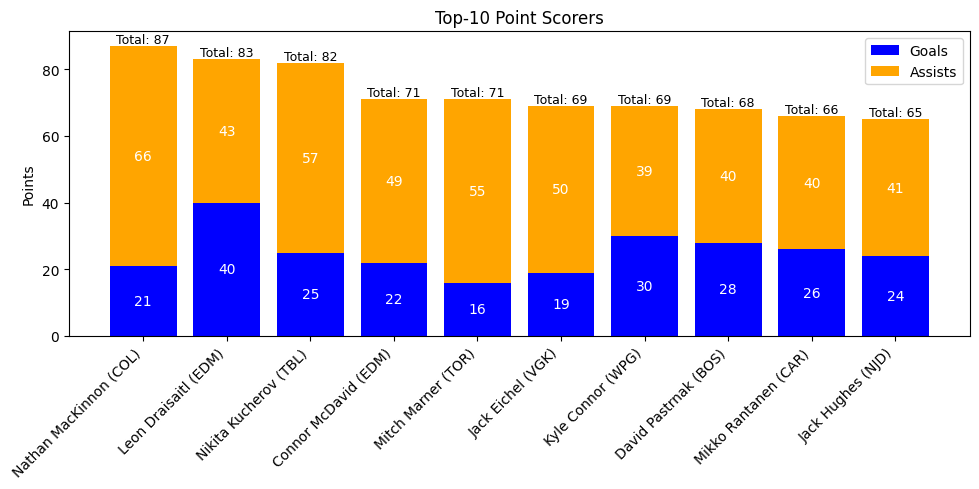

In [204]:
fig, ax = plt.subplots(figsize=(10,5))
bars_goals = ax.bar(players, goals, label='Goals', color='blue')
bars_assists = ax.bar(players, assists, label='Assists', bottom=goals, color='orange')

for bar_goal, bar_assist, goal, assist in zip(bars_goals, bars_assists, goals, assists):
    # Label for Goals
    ax.text(
        bar_goal.get_x() + bar_goal.get_width() / 2,  # Center x-coordinate
        bar_goal.get_height() / 2,                   # Midpoint of the bar
        str(goal),                                   # Goal value
        ha='center', va='center', color='white'
    )
    
    # Label for Assists
    ax.text(
        bar_assist.get_x() + bar_assist.get_width() / 2,  # Center x-coordinate
        bar_goal.get_height() + bar_assist.get_height() / 2,  # Midpoint of the top bar
        str(assist),                                     # Assist value
        ha='center', va='center', color='white'
    )

# Add total points label above the stacked bars
for i, total in enumerate(top10_point_scorers['points']):
    ax.text(
        i,                                               # x-coordinate (index of bar)
        goals.iloc[i] + assists.iloc[i],             # Slightly above the top bar
        f"Total: {total}",                               # Total points value
        ha='center', va='bottom', fontsize=9, color='black'
    )

ax.set_title('Top-10 Point Scorers')
ax.set_ylabel('Points')
ax.legend()

plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

### Goalie Save Percentage against the League average 

In [205]:
df_goalies_performance.head()

,gameId,teamAbbrev,homeRoadFlag,gameDate,goals,assists,gamesStarted,decision,shotsAgainst,goalsAgainst,...,firstName,lastName,sweaterNumber,positionCode,shootsCatches,heightInCentimeters,weightInKilograms,birthDate,birthCountry,team_abbr
0,2024020852,WPG,H,2025-02-04,0,0,1,W,29,0,...,Eric,Comrie,1.0,G,L,185,86,1995-07-06,CAN,WPG
1,2024020791,WPG,H,2025-01-26,0,0,1,W,22,2,...,Eric,Comrie,1.0,G,L,185,86,1995-07-06,CAN,WPG
2,2024020730,WPG,H,2025-01-18,0,0,1,L,21,2,...,Eric,Comrie,1.0,G,L,185,86,1995-07-06,CAN,WPG
3,2024020667,WPG,H,2025-01-10,0,0,1,O,23,2,...,Eric,Comrie,1.0,G,L,185,86,1995-07-06,CAN,WPG
4,2024020597,WPG,R,2024-12-31,0,0,1,L,36,3,...,Eric,Comrie,1.0,G,L,185,86,1995-07-06,CAN,WPG


In [206]:
top5_goalies_save_pct = df_goalies_performance.groupby(by=['id']).agg(
    shotsAgainst = ('shotsAgainst', 'sum'),
    goalsAgainst = ('goalsAgainst', 'sum'),
    gamesPlayed = ('gameId', 'count')
    ).reset_index()

In [207]:
top5_goalies_save_pct['savePct'] = 1 - top5_goalies_save_pct['goalsAgainst']/top5_goalies_save_pct['shotsAgainst']

In [208]:
min_games_played = (df_goalies_performance.groupby('team_abbr')['gameDate'].count().mean() * 0.35).round()

In [209]:
min_games_played

np.float64(19.0)

In [210]:
top5_goalies_save_pct.loc[top5_goalies_save_pct['gamesPlayed'] > min_games_played].sort_values(by=['savePct'], ascending=False).reset_index().drop(columns=['index']).head(5)

,id,shotsAgainst,goalsAgainst,gamesPlayed,savePct
0,8476945,1188,89,43,0.925084
1,8480313,873,69,31,0.920962
2,8476883,1195,98,43,0.917992
3,8475311,767,63,29,0.917862
4,8478406,1163,98,41,0.915735


In [211]:
top5_goalies_save_pct = top5_goalies_save_pct.loc[top5_goalies_save_pct['gamesPlayed'] > min_games_played].sort_values(by=['savePct'], ascending=False).reset_index().drop(columns=['index']).head(5)

In [212]:
top5_goalies_save_pct_ids = top5_goalies_save_pct['id']

In [213]:
top5_goalies_save_pct_logs = df_goalies_performance[
    df_goalies_performance['id'].isin(top5_goalies_save_pct_ids)
    ][['id', 'gameDate','firstName', 'lastName', 'team_abbr', 'shotsAgainst', 'goalsAgainst']].sort_values(by=['id', 'gameDate'])

In [214]:
top5_goalies_save_pct_logs['id'].unique()

array([8475311, 8476883, 8476945, 8478406, 8480313])

In [215]:
top5_goalies_save_pct_logs['savePercent'] = 1 - top5_goalies_save_pct_logs['goalsAgainst'] / top5_goalies_save_pct_logs ['shotsAgainst']

In [216]:
top5_goalies_save_pct_logs.groupby('id')['savePercent'].rolling(window=5, min_periods=1).mean().reset_index(level=0, drop=True)

685    0.969697
684    0.946387
683    0.899217
682    0.905182
681    0.901069
         ...   
85     0.970913
84     0.970913
83     0.937580
82     0.919398
81     0.900295
Name: savePercent, Length: 187, dtype: float64

In [217]:
top5_goalies_save_pct_logs['rollingSavePercent'] = top5_goalies_save_pct_logs.groupby('id')['savePercent'].rolling(window=5, min_periods=1).mean().reset_index(level=0, drop=True)

In [218]:
top5_goalies_save_pct_logs['label'] = top5_goalies_save_pct_logs['firstName'] + ' ' + top5_goalies_save_pct_logs['lastName'] + ' (' + top5_goalies_save_pct_logs['team_abbr'] + ')'

In [219]:
top5_goalies_save_pct_logs.info()

<class 'pandas.core.frame.DataFrame'>
Index: 187 entries, 685 to 81
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   id                  187 non-null    int64  
 1   gameDate            187 non-null    object 
 2   firstName           187 non-null    object 
 3   lastName            187 non-null    object 
 4   team_abbr           187 non-null    object 
 5   shotsAgainst        187 non-null    int64  
 6   goalsAgainst        187 non-null    int64  
 7   savePercent         187 non-null    float64
 8   rollingSavePercent  187 non-null    float64
 9   label               187 non-null    object 
dtypes: float64(2), int64(3), object(5)
memory usage: 16.1+ KB


In [220]:
top5_goalies_save_pct_logs = top5_goalies_save_pct_logs.astype({'gameDate': 'datetime64[s]'})

In [221]:
top5_goalies_save_pct_logs

,id,gameDate,firstName,lastName,team_abbr,shotsAgainst,goalsAgainst,savePercent,rollingSavePercent,label
685,8475311,2024-10-10,Darcy,Kuemper,LAK,33,1,0.969697,0.969697,Darcy Kuemper (LAK)
684,8475311,2024-10-12,Darcy,Kuemper,LAK,26,2,0.923077,0.946387,Darcy Kuemper (LAK)
683,8475311,2024-10-14,Darcy,Kuemper,LAK,41,8,0.804878,0.899217,Darcy Kuemper (LAK)
682,8475311,2024-10-26,Darcy,Kuemper,LAK,26,2,0.923077,0.905182,Darcy Kuemper (LAK)
681,8475311,2024-10-30,Darcy,Kuemper,LAK,26,3,0.884615,0.901069,Darcy Kuemper (LAK)
...,...,...,...,...,...,...,...,...,...,...
85,8480313,2025-01-21,Logan,Thompson,WSH,32,2,0.937500,0.970913,Logan Thompson (WSH)
84,8480313,2025-01-28,Logan,Thompson,WSH,33,1,0.969697,0.970913,Logan Thompson (WSH)
83,8480313,2025-02-01,Logan,Thompson,WSH,30,5,0.833333,0.937580,Logan Thompson (WSH)
82,8480313,2025-02-04,Logan,Thompson,WSH,33,3,0.909091,0.919398,Logan Thompson (WSH)


In [222]:
all_dates = pd.date_range(start=top5_goalies_save_pct_logs['gameDate'].min(), end=top5_goalies_save_pct_logs['gameDate'].max())

In [223]:
aligned_data = []

for id, group in top5_goalies_save_pct_logs.groupby('id'):
    group = group.set_index('gameDate').reindex(all_dates)
    group['id'] = id
    group['rollingSavePercent'] = group['rollingSavePercent'].interpolate(limit_area='inside')
    aligned_data.append(group)

top5_goalies_save_pct_logs_aligned = pd.concat(aligned_data)

top5_goalies_save_pct_logs_aligned = top5_goalies_save_pct_logs_aligned.reset_index().rename(columns={'index':'gameDate'})

top5_goalies_save_pct_logs_aligned['label'] = (
    top5_goalies_save_pct_logs_aligned['label'].dropna()
)

In [224]:
top5_goalies_save_pct_logs_aligned.loc[top5_goalies_save_pct_logs_aligned['id'] == 8480843].head()

,gameDate,id,firstName,lastName,team_abbr,shotsAgainst,goalsAgainst,savePercent,rollingSavePercent,label


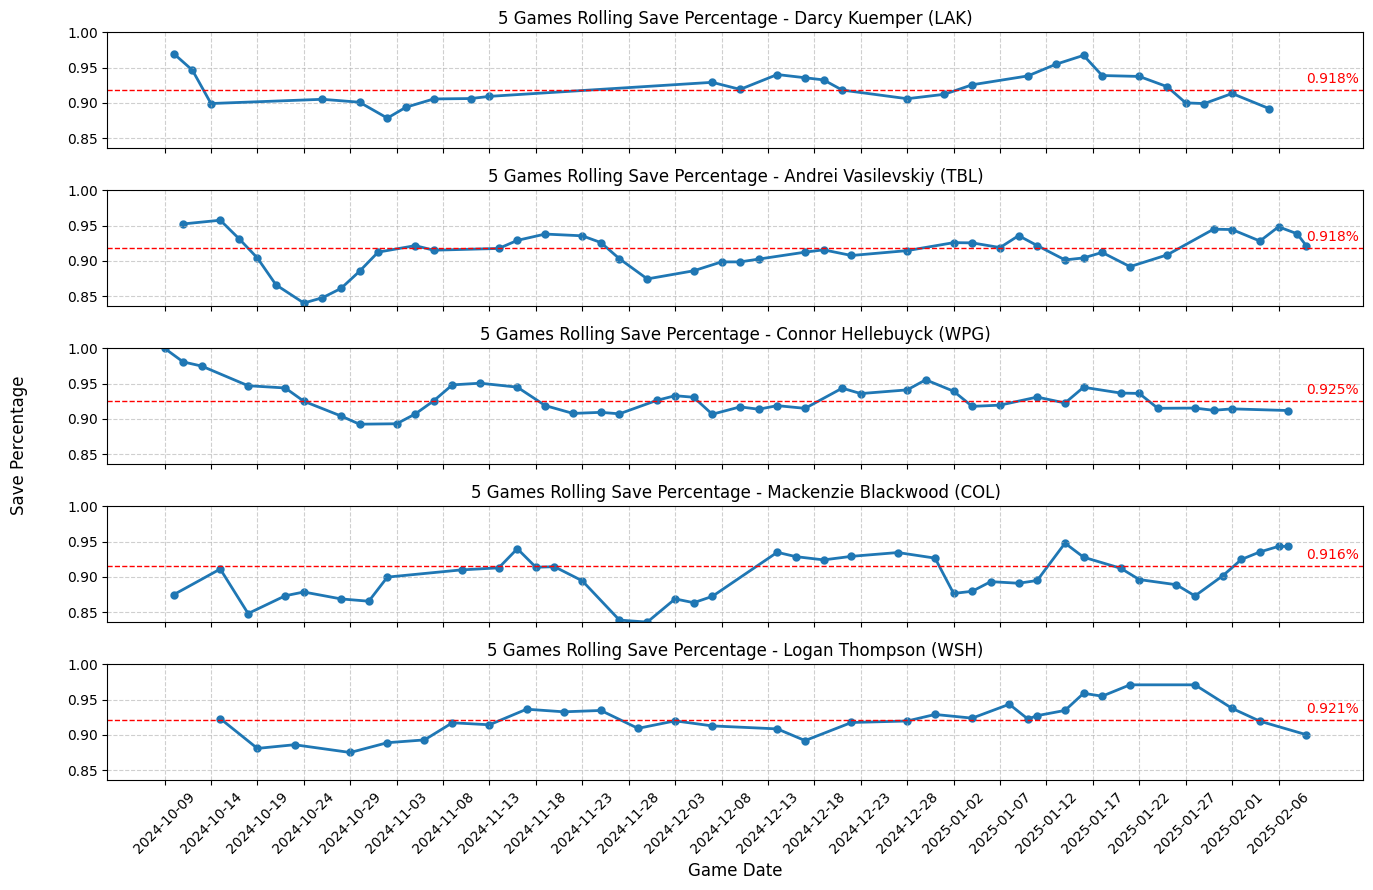

In [225]:
# Determine global Y-axis limits
y_min = top5_goalies_save_pct_logs_aligned['rollingSavePercent'].min()
y_max = top5_goalies_save_pct_logs_aligned['rollingSavePercent'].max()

fig, axes = plt.subplots(nrows=5, ncols=1, figsize=(14, 10), sharex=True)

# Iterate over subplots and goalie data
for ax, (id, group) in zip(axes, top5_goalies_save_pct_logs_aligned.groupby('id')):
    group_label = group['label'][group['label'].notnull()].unique()[0]
    avg_save_pct = 1- group['goalsAgainst'].sum() / group['shotsAgainst'].sum()

    # Line plot for rolling save percentage
    ax.plot(
        group['gameDate'], 
        group['rollingSavePercent'], 
        label=group_label,
        linewidth=2
    )
    
    # Scatter plot for save percentage points
    ax.scatter(
        group.loc[group['savePercent'].notna()]['gameDate'],
        group.loc[group['savePercent'].notna()]['rollingSavePercent'],
        marker='.',
        linewidths=3
    )

    ax.axhline(
        y=avg_save_pct,
        linewidth=1,
        linestyle='--',
        color='red',
        label=f'Avg. Save %'
    )

    ax.text(
        group['gameDate'].iloc[-1],  # Last game's date for placement
        avg_save_pct + 0.01,
        f"{avg_save_pct:.3f}%", 
        color='red', 
        fontsize=10, 
    )

    # Title, grid, and set uniform Y-axis limits
    ax.set_title(f"5 Games Rolling Save Percentage - {group_label}", fontsize=12)
    ax.grid(True, linestyle='--', alpha=0.6)
    ax.set_ylim(y_min, y_max)  # Set consistent Y limits

# Global settings
axes[-1].set_xlabel('Game Date', fontsize=12)  # Add X-axis label only to the last subplot

# Global Y-axis label placed outside the chart area
fig.text(0.02, 0.5, 'Save Percentage', va='center', rotation='vertical', fontsize=12)

# Set uniform X ticks and format
xticks = top5_goalies_save_pct_logs_aligned['gameDate'].unique()  # Get unique X values
axes[-1].set_xticks(xticks[::5])  # Use every 5th tick for clarity
axes[-1].tick_params(axis='x', rotation=45)


# Adjust layout
plt.tight_layout(rect=[0.05, 0.05, 1, 0.95])  # Add padding for labels
plt.show()


## Load data in Google Cloud Storage

In [339]:
from google.cloud import storage
import datetime

In [340]:
import os
os.environ["GOOGLE_APPLICATION_CREDENTIALS"]="creds/creds.json"

In [341]:
bucket_name = 'nhl-api-bucket'

In [342]:
client = storage.Client()

In [343]:
client.get_bucket(bucket_name)

<Bucket: nhl-api-bucket>

Uploading df_skaters_performance and df_goalies_performance data into a cloud bucket.

In [344]:
bucket = client.bucket('nhl-api-bucket')

In [345]:
ts = datetime.datetime.now().strftime("%d-%m-%Y-%H-%M-%S")

In [346]:
file_name = f"skaters_performance_{ts}"
blob = bucket.blob(f'{file_name}.csv')

In [347]:
blob.upload_from_string(df_skaters_performance.to_csv(index=False), 'text/csv')

Load data from GCS into a BQ table

In [348]:
from google.cloud import bigquery

In [349]:
bq_client = bigquery.Client()

In [350]:
dataset_id = "stg_nhl_data"

try: 
    bq_client.get_dataset(dataset_id)
except Exception:
    bq_client.create_dataset(dataset_id)

In [351]:
table_id = f"silent-effect-287314.{dataset_id}.{file_name}"

In [ ]:
def infer_schema(df):
    schema = []
    for col, dtype in zip(df.columns, df.dtypes):
        if dtype == "int64":
            field_type = "INT64"
        elif dtype == "float64":
            field_type = "FLOAT"
        elif dtype == "object":
            field_type = "STRING"
        elif dtype.name.startswith("datetime"):
            field_type = "DATETIME"
        else:
            field_type = "STRING"
        schema.append(bigquery.SchemaField(col, field_type))
    return schema

In [358]:
schema = infer_schema(df_skaters_performance)

In [ ]:
job_config = bigquery.LoadJobConfig(
    schema=schema
    skip_leading_rows=1
)

In [353]:
uri = f"gs://{bucket_name}/{file_name}.csv"

In [354]:
load_job = bq_client.load_table_from_uri(
    uri, table_id, job_config=job_config
)

In [355]:
load_job.result()  # Waits for the job to complete.

LoadJob<project=silent-effect-287314, location=US, id=be664fa6-64b1-4c1c-8967-ad1a9c8f7d14>

In [356]:
destination_table = bq_client.get_table(table_id)
print("Loaded {} rows.".format(destination_table.num_rows))

Loaded 22274 rows.
